In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss

Season 2008: Brier Score = 0.1693
Season 2009: Brier Score = 0.1982
Season 2010: Brier Score = 0.2175
Season 2011: Brier Score = 0.2213
Season 2012: Brier Score = 0.2135
Season 2013: Brier Score = 0.2239
Season 2014: Brier Score = 0.2130
Season 2015: Brier Score = 0.1826
Season 2016: Brier Score = 0.2029
Season 2017: Brier Score = 0.2097
Season 2018: Brier Score = 0.2090
Season 2019: Brier Score = 0.1887
Season 2021: Brier Score = 0.2259
Season 2022: Brier Score = 0.2553
Season 2023: Brier Score = 0.2168
Season 2024: Brier Score = 0.2107


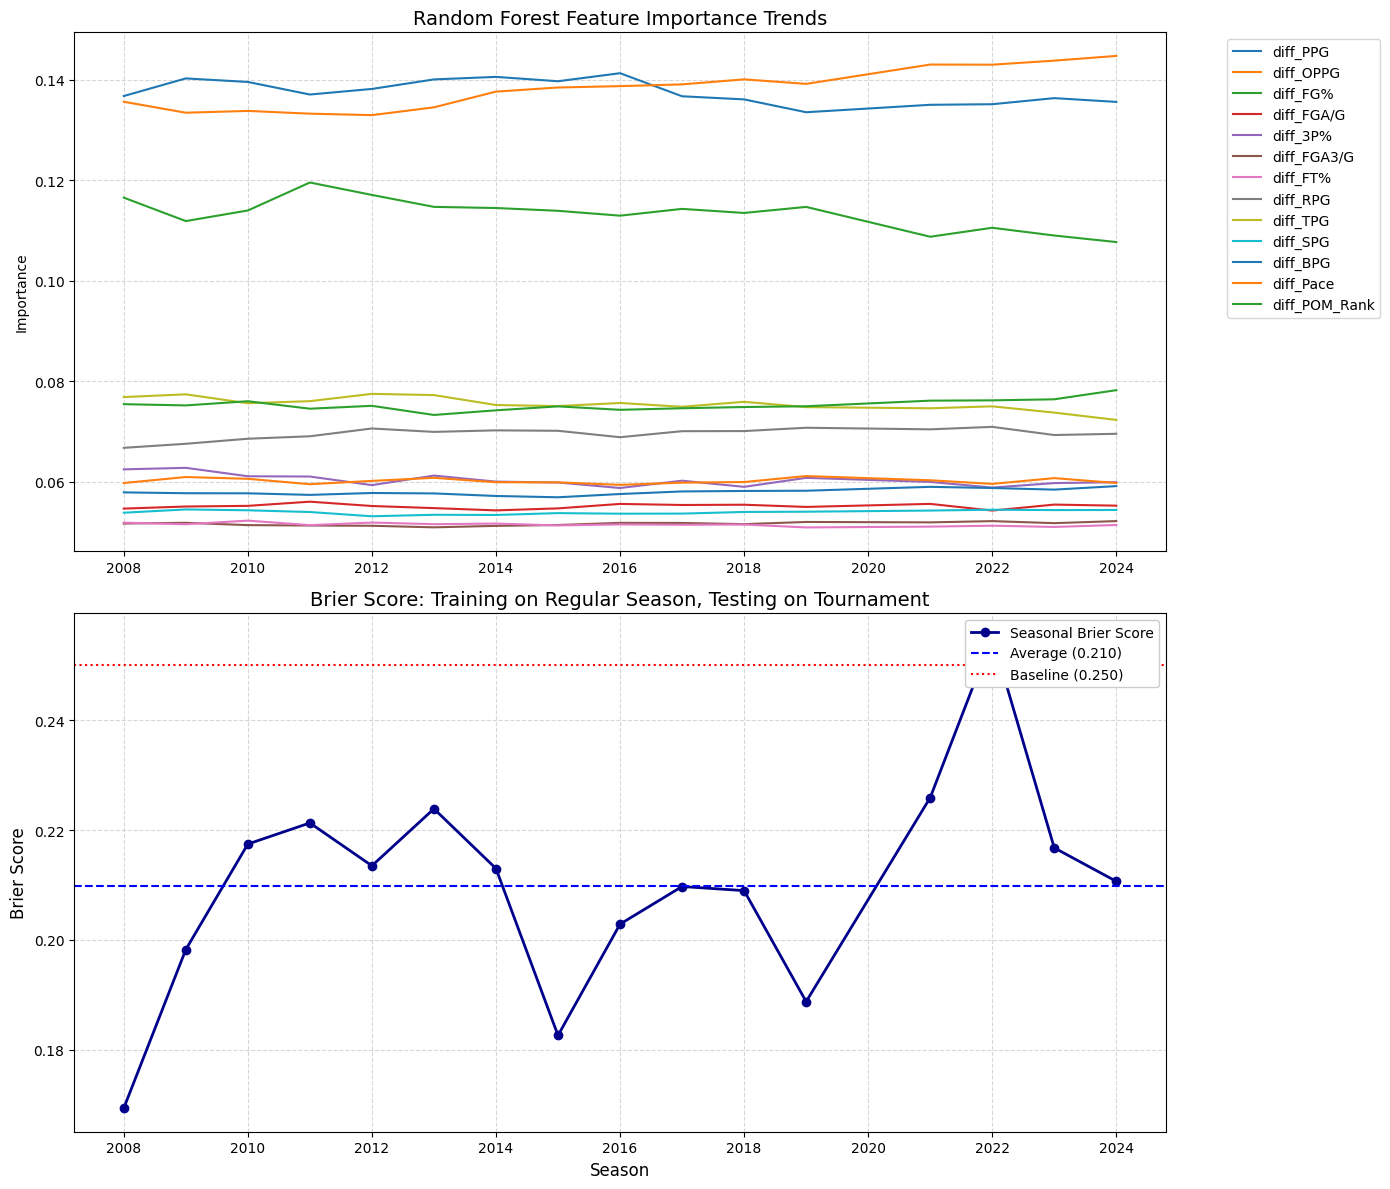


=== Validation Results ===
 Season  Brier Score
   2008     0.169340
   2009     0.198238
   2010     0.217459
   2011     0.221303
   2012     0.213496
   2013     0.223886
   2014     0.212998
   2015     0.182590
   2016     0.202868
   2017     0.209721
   2018     0.208976
   2019     0.188749
   2021     0.225912
   2022     0.255251
   2023     0.216763
   2024     0.210660

Average Brier Score: 0.2099
Best Brier Score: 0.1693 in 2008

Baseline Brier Score (for reference): 0.2500


In [ ]:
game_df = pd.read_csv('class_data/reg_season_final.csv')
tourney_df = pd.read_csv('class_data/tourney_final.csv')

# Features to use
features = ['diff_PPG', 'diff_OPPG', 'diff_FG%', 
            'diff_FGA/G', 'diff_3P%', 'diff_FGA3/G', 'diff_FT%', 
            'diff_RPG', 'diff_TPG', 'diff_SPG', 'diff_BPG', 'diff_Pace', 
            'diff_POM_Rank']

# Initialize storage
brier_scores = []
seasons = sorted([s for s in tourney_df['Season'].unique() if s >= 2008])
feature_importance_history = {feature: [] for feature in features}
baseline_brier = game_df['target'].mean() * (1 - game_df['target'].mean())  # Baseline for reference

for season in seasons:
    train_data = game_df[game_df['Season'] < season]
    test_data = tourney_df[tourney_df['Season'] == season]
    
    # Skip if not enough training data
    if len(train_data) < 100 or len(test_data) == 0:
        print(f"Skipping {season} - insufficient data")
        continue
    
    X_train = train_data[features]
    y_train = train_data['target']
    X_test = test_data[features]
    y_test = test_data['target']
    
    # Train Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict probabilities for Brier score
    y_proba = model.predict_proba(X_test)[:, 1]
    brier_score = brier_score_loss(y_test, y_proba)
    brier_scores.append(brier_score)
    
    # Store feature importances
    for feature, imp in zip(features, model.feature_importances_):
        feature_importance_history[feature].append(imp)
    
    print(f"Season {season}: Brier Score = {brier_score:.4f}")

# Create figure with 2 subplots (Brier Score + Feature Importance)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Feature Importance Plot
for feature in features:
    ax1.plot(seasons[-len(brier_scores):], feature_importance_history[feature], label=feature)
ax1.set_title('Random Forest Feature Importance Trends', fontsize=14)
ax1.set_ylabel('Importance')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.5)

# Brier score plot
avg_brier = np.mean(brier_scores)
ax2.plot(seasons[-len(brier_scores):], brier_scores, marker='o', color='darkblue', linewidth=2, label='Seasonal Brier Score')
ax2.axhline(y=avg_brier, color='blue', linestyle='--', linewidth=1.5, 
            label=f'Average ({avg_brier:.3f})')
ax2.axhline(y=baseline_brier, color='red', linestyle=':', linewidth=1.5, 
            label=f'Baseline ({baseline_brier:.3f})')
ax2.set_xlabel('Season', fontsize=12)
ax2.set_ylabel('Brier Score', fontsize=12)
ax2.set_title('Brier Score: Training on Regular Season, Testing on Tournament', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(loc='upper right', framealpha=1)

plt.tight_layout()
plt.show()

# Results summary
print("\n=== Validation Results ===")
results_df = pd.DataFrame({
    'Season': seasons[-len(brier_scores):],
    'Brier Score': brier_scores,
})
print(results_df.to_string(index=False))

print(f"\nAverage Brier Score: {np.mean(brier_scores):.4f}")
print(f"Best Brier Score: {min(brier_scores):.4f} in {results_df.loc[np.argmin(brier_scores), 'Season']}")
print(f"\nBaseline Brier Score (for reference): {baseline_brier:.4f}")